### Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import numpy as np

print('Libraries imported.')

Libraries imported.


### Download zipcode data from we and create data frame

In [ ]:
table_TO = pd.read_html('https://www.zipcodestogo.com/North%20Carolina/')

In [ ]:
print(f'Total tables: {len(table_TO)}')

In [ ]:
#Guess that it is the first table
df = table_TO[1]
df.head()

In [ ]:
#Size before cleaning
df.shape

### Cleanup Zipcode data frame 

In [ ]:
df=df.drop([0,1])

In [ ]:
df.shape

In [ ]:
df=df.drop(3, axis=1)

In [ ]:
df.head()

In [ ]:
df=df.rename(columns={0: 'Zip Code', 1: 'City',2: 'County'})

In [ ]:
df2=df.loc[df['County'] == 'Mecklenburg']

In [ ]:
#filter for Charlotte Only
df2=df.loc[df['City'] == 'Charlotte']

In [ ]:
df2.head()

In [ ]:
#Drop county
df2=df2.drop('County', axis=1)

In [ ]:
df2.shape

In [ ]:
#Condition downloaded latitude lognitude file
PCLATLON=pd.read_csv('gsclt.csv') #pclatlon contained over 43,000 zipcodes with latitude longitude

In [ ]:
PCLATLON.head()

In [ ]:
PCLATLON=PCLATLON.rename(columns={'Zip': 'Zip Code'})

In [ ]:
PCLATLON=PCLATLON.drop(['State','Timezone','Daylight savings time flag','geopoint'],axis='columns')

In [ ]:
PCLATLON.head()

In [ ]:
print(PCLATLON.dtypes)

In [ ]:
PCLATLON['Zip Code'] = PCLATLON['Zip Code'].astype('object')

In [ ]:
print(PCLATLON.dtypes)

### Create merge of lat lon and zip codes for charlotte area.

In [ ]:
zips = pd.merge(df2,
                 PCLATLON[['Zip Code','Latitude', 'Longitude']],on='Zip Code')
zips.head()

In [ ]:
zips=PCLATLON.merge(df2, left_on='Zip Code', right_on='Zip Code')

In [ ]:
zips.head()

In [ ]:
zips=pd.merge( PCLATLON, df2, on=['Zip Code'], how='outer')

In [ ]:
zips=zips.loc[zips['City_x'] == 'Charlotte']

In [ ]:
zips.head()

In [ ]:
zips.shape

In [ ]:
zips=zips.drop('City_y', axis=1)

In [ ]:
zips=zips.rename(columns={'City_x': 'City'})

In [ ]:
zips.head()

In [ ]:
zips.drop([2041])

In [ ]:
print(zips)

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
zips=zips.drop([2041,16263,21675,23410,32259,34926])

###  Because no neighborhood data existed for zip code names, had to create manually from map

In [2]:
zips=pd.read_csv('charlotte.csv')

### Let's get the geographical coordinates of Charlotte

In [3]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Charlotte, NC'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Charlotte are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Charlotte are 35.2272086, -80.8430827.


### Let's visualize Charlotte with the neighborhoods. 

In [4]:
import folium # map rendering library

# create map of New York using latitude and longitude values
map_charlotte = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(zips['Latitude'], zips['Longitude'],zips['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_charlotte)  
    
map_charlotte

### Define Foursquare Credentials and Version 

In [5]:
CLIENT_ID = 'S3IVNSJ3WG4Q2JY222OV4EZE4NFJP0AWDY3OX5ZXJ4ZAS0RG' # your Foursquare ID
CLIENT_SECRET = 'V3UPS1CTX4KSEPQ2ETFBDRQIRT3T4KEAJKQ2NG24EOZRICND' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: S3IVNSJ3WG4Q2JY222OV4EZE4NFJP0AWDY3OX5ZXJ4ZAS0RG
CLIENT_SECRET:V3UPS1CTX4KSEPQ2ETFBDRQIRT3T4KEAJKQ2NG24EOZRICND


###  Let's explore the first neighborhood in our dataframe.

In [6]:
zips.loc[0, 'Neighborhood']

'Uptown South'

In [7]:
#Get the neighborhood's latitude and longitude values.
neighborhood_latitude = zips.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = zips.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = ['Uptown South'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of ['Uptown South'] are 35.260020000000004, -80.804151.


In [8]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=S3IVNSJ3WG4Q2JY222OV4EZE4NFJP0AWDY3OX5ZXJ4ZAS0RG&client_secret=V3UPS1CTX4KSEPQ2ETFBDRQIRT3T4KEAJKQ2NG24EOZRICND&v=20180605&ll=35.260020000000004,-80.804151&radius=500&limit=100'

In [9]:
#send GET request
import requests # library to handle requests
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '602c5716443e2c530021b42a'},
 'response': {'headerLocation': 'Sugaw Creek',
  'headerFullLocation': 'Sugaw Creek, Charlotte',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 35.26452000450001,
    'lng': -80.79865022953052},
   'sw': {'lat': 35.2555199955, 'lng': -80.80965177046949}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5fb6629f6628442f48018c8d',
       'name': 'Cable, Internet and Phone Bundle Retailer',
       'location': {'lat': 35.259730241387835,
        'lng': -80.80569714344165,
        'labeledLatLngs': [{'label': 'display',
          'lat': 35.259730241387835,
          'lng': -80.80569714344165}],
        'distance': 144,
        'postalCode': '28201',
      

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [11]:
import json # library to handle JSON files

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,"Cable, Internet and Phone Bundle Retailer",Business Service,35.259730,-80.805697
1,Same Day Appliance Service,Electronics Store,35.259532,-80.803328
2,Best Rate Plumbing,Home Service,35.261442,-80.806149
3,State Of Appiness,IT Services,35.263211,-80.800517


In [12]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Let's explore all the neighborhoods in Charlotte 

In [14]:
charlotte_venues = getNearbyVenues(names=zips['Neighborhood'],
                                   latitudes=zips['Latitude'],
                                   longitudes=zips['Longitude']
                                  )

Uptown South
Uptown North
Dilworth
Elizabeth
Midwood
Druid Hills
Eastover
Pinecrest
Selwyn Park
Quail Hollow
Cotswold
Parkview East
Newell
Wildwood
Robinson Church
Spring Lake
Springfield
Briarcreek
Airport
Park Road
Allen Hills
Grier Heights
College Downs
Montclaire
Tuckaway Park
Mint Hill
Westerly Hills
Four Seasons
Uptown East
Greycrest
Toddville Road
Carmel
Prosperity Church Road
Newell South
University City North
Croft
Hembstead
Taragate Farms
Queens College
Ballantyne
Steele Creek
Sharon Colony
Lincoln Heights
Commonwealth


In [15]:
#Lets check the dataframe
print(charlotte_venues.shape)
charlotte_venues.head()

(347, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Uptown South,35.260020,-80.804151,"Cable, Internet and Phone Bundle Retailer",35.259730,-80.805697,Business Service
1,Uptown South,35.260020,-80.804151,Same Day Appliance Service,35.259532,-80.803328,Electronics Store
2,Uptown South,35.260020,-80.804151,Best Rate Plumbing,35.261442,-80.806149,Home Service
3,Uptown South,35.260020,-80.804151,State Of Appiness,35.263211,-80.800517,IT Services
4,Uptown North,35.227192,-80.844190,Blumenthal Performing Arts Center,35.227930,-80.841951,Performing Arts Venue


In [16]:
#group by venue
charlotte_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Airport,4,4,4,4,4,4
Allen Hills,4,4,4,4,4,4
Ballantyne,11,11,11,11,11,11
Briarcreek,4,4,4,4,4,4
Carmel,8,8,8,8,8,8
College Downs,20,20,20,20,20,20
Commonwealth,4,4,4,4,4,4
Cotswold,2,2,2,2,2,2
Croft,5,5,5,5,5,5


In [17]:
#How many unique values
print('There are {} uniques categories.'.format(len(charlotte_venues['Venue Category'].unique())))

There are 137 uniques categories.


In [18]:
# one hot encoding
charlotte_onehot = pd.get_dummies(charlotte_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
charlotte_onehot['Neighborhood'] = charlotte_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [charlotte_onehot.columns[-1]] + list(charlotte_onehot.columns[:-1])
charlotte_onehot = charlotte_onehot[fixed_columns]

charlotte_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Bed & Breakfast,Bistro,Botanical Garden,Boxing Gym,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Gym,College Library,College Rec Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Discount Store,Dive Bar,Doctor's Office,Donut Shop,Electronics Store,Event Space,Fast Food Restaurant,Food,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Garden Center,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,High School,Historic Site,History Museum,Home Service,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Korean Restaurant,Latin American Restaurant,Lawyer,Liquor Store,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Moving Target,Nail Salon,New American Restaurant,Paintball Field,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pharmacy,Picnic Area,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Ramen Restaurant,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shopping Mall,Smoke Shop,Smoothie Shop,Soccer Field,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Trail,Wine Bar,Wings Joint,Women's Store
0,Uptown South,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Uptown South,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Uptown South,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Uptown South,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Uptown North,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
#What is the size of the new dataframe
charlotte_onehot.shape

(347, 138)

In [20]:
#Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
charlotte_grouped = charlotte_onehot.groupby('Neighborhood').mean().reset_index()
charlotte_grouped

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Bed & Breakfast,Bistro,Botanical Garden,Boxing Gym,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Gym,College Library,College Rec Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Discount Store,Dive Bar,Doctor's Office,Donut Shop,Electronics Store,Event Space,Fast Food Restaurant,Food,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Garden Center,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,High School,Historic Site,History Museum,Home Service,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Korean Restaurant,Latin American Restaurant,Lawyer,Liquor Store,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Moving Target,Nail Salon,New American Restaurant,Paintball Field,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pharmacy,Picnic Area,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Ramen Restaurant,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shopping Mall,Smoke Shop,Smoothie Shop,Soccer Field,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Trail,Wine Bar,Wings Joint,Women's Store
0,Airport,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,0.00,0.000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.25,0.00,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.0,0.0,0.00,0.25,0.00,0.00,0.00,0.25,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.0,0.00,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Allen Hills,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,0.00,0.000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.25,0.00,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.0,0.0,0.00,0.25,0.00,0.00,0.00,0.25,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.0,0.00,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Ballantyne,0.090909,0.000000,0.00,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.090909,0.000000,0.000000,0.00,0.090909,0.00

In [21]:
#size
charlotte_grouped.shape

(41, 138)

In [22]:
#Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in charlotte_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = charlotte_grouped[charlotte_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Airport----
                   venue  freq
0            IT Services  0.25
1           Home Service  0.25
2       Business Service  0.25
3      Electronics Store  0.25
4  Performing Arts Venue  0.00


----Allen Hills----
                   venue  freq
0            IT Services  0.25
1           Home Service  0.25
2       Business Service  0.25
3      Electronics Store  0.25
4  Performing Arts Venue  0.00


----Ballantyne----
                 venue  freq
0  American Restaurant  0.09
1      Supplement Shop  0.09
2  Japanese Restaurant  0.09
3          Pizza Place  0.09
4         Dance Studio  0.09


----Briarcreek----
                   venue  freq
0            IT Services  0.25
1           Home Service  0.25
2       Business Service  0.25
3      Electronics Store  0.25
4  Performing Arts Venue  0.00


----Carmel----
              venue  freq
0  Business Service  0.38
1  Insurance Office  0.12
2             Trail  0.12
3              Café  0.12
4     Deli / Bodega  0.12


----College D

In [23]:
#### Let's put that into a _pandas_ dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
#Now let's create the new dataframe and display the top 10 venues for each neighborhood.
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = charlotte_grouped['Neighborhood']

for ind in np.arange(charlotte_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(charlotte_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Airport,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio
1,Allen Hills,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio
2,Ballantyne,American Restaurant,Supplement Shop,Restaurant,Salon / Barbershop,Sandwich Place,Dance Studio,Business Service,Breakfast Spot,Spa,Japanese Restaurant
3,Briarcreek,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio
4,Carmel,Business Service,Trail,Gym,Insurance Office,Café,Deli / Bodega,Women's Store,Dance Studio,Doctor's Office,Dive Bar


### Cluster the Neighborhoods 

In [25]:
from sklearn.cluster import KMeans
#Run _k_-means to cluster the neighborhood into 4 clusters.
# set number of clusters
kclusters = 5

charlotte_grouped_clustering = charlotte_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, verbose=1,algorithm='full',max_iter=1000).fit(charlotte_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

Initialization complete
Iteration 0, inertia 6.7011165773849966
Iteration 1, inertia 4.880224125643319
Iteration 2, inertia 4.855031040413859
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.371852693330392
Iteration 1, inertia 5.834666515114404
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.873519359997059
Iteration 1, inertia 6.339295061406224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.613246404194687
Iteration 1, inertia 6.121242402581102
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.37885270475687
Iteration 1, inertia 4.880224125643319
Iteration 2, inertia 4.855031040413859
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.919496404194687
Iteration 1, inertia 5.292249669944074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 

array([0, 0, 1, 0, 1, 1, 0, 1, 1, 1])

In [26]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

charlotte_merged = zips

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
charlotte_merged = charlotte_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

charlotte_merged.head() # check the last columns!

,Unnamed: 0,Zip Code,City,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,11812,28201,Charlotte,35.260020,-80.804151,Uptown South,0.0,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio
1,11813,28202,Charlotte,35.227192,-80.844190,Uptown North,1.0,Pizza Place,Steakhouse,Sandwich Place,Restaurant,Theater,Pub,Hotel,American Restaurant,Park,Lounge
2,11814,28203,Charlotte,35.208992,-80.855390,Dilworth,1.0,American Restaurant,Bar,Spa,Ice Cream Shop,Pub,Pool Hall,Pizza Place,Pharmacy,Park,Paper / Office Supplies Store
3,11815,28204,Charlotte,35.214693,-80.826650,Elizabeth,1.0,Pizza Place,New American Restaurant,Greek Restaurant,Deli / Bodega,Park,Convenience Store,Chinese Restaurant,Rock Club,Mexican Restaurant,Sandwich Place
4,11816,28205,Charlotte,35.222406,-80.792210,Midwood,1.0,Park,Auto Workshop,Women's Store,Electronics Store,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Deli / Bodega,Dance Studio


In [27]:
charlotte_merged = charlotte_merged.dropna(subset=['Cluster Labels'])

In [28]:
charlotte_merged['Cluster Labels'] = charlotte_merged['Cluster Labels'].astype(np.int64)

In [29]:
import matplotlib
from matplotlib import cm
from matplotlib import colors

In [30]:
# create clustered map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(charlotte_merged['Latitude'], charlotte_merged['Longitude'], charlotte_merged['Neighborhood'], charlotte_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine the Clusters 

In [31]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 0, charlotte_merged.columns[[1] + list(range(5, charlotte_merged.shape[1]))]]

,Zip Code,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,28201,Uptown South,0,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio
17,28218,Briarcreek,0,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio
18,28219,Airport,0,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio
19,28220,Park Road,0,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio
20,28221,Allen Hills,0,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio
21,28222,Grier Heights,0,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio
23,28224,Montclaire,0,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio
26,28228,Westerly Hills,0,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio
27,28229,Four Seasons,0,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio
28,28230,Uptown East,0,Home Service,Electronics Store,IT Services,Business Service,Deli / Bodega,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio


In [32]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 1, charlotte_merged.columns[[1] + list(range(5, charlotte_merged.shape[1]))]]

,Zip Code,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,28202,Uptown North,1,Pizza Place,Steakhouse,Sandwich Place,Restaurant,Theater,Pub,Hotel,American Restaurant,Park,Lounge
2,28203,Dilworth,1,American Restaurant,Bar,Spa,Ice Cream Shop,Pub,Pool Hall,Pizza Place,Pharmacy,Park,Paper / Office Supplies Store
3,28204,Elizabeth,1,Pizza Place,New American Restaurant,Greek Restaurant,Deli / Bodega,Park,Convenience Store,Chinese Restaurant,Rock Club,Mexican Restaurant,Sandwich Place
4,28205,Midwood,1,Park,Auto Workshop,Women's Store,Electronics Store,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Deli / Bodega,Dance Studio
5,28206,Druid Hills,1,American Restaurant,Lawyer,Coffee Shop,Discount Store,Deli / Bodega,Electronics Store,Donut Shop,Doctor's Office,Dive Bar,Dance Studio
6,28207,Eastover,1,Italian Restaurant,American Restaurant,French Restaurant,Fried Chicken Joint,Sculpture Garden,Jewelry Store,Nail Salon,Bed & Breakfast,Food,Coffee Shop
8,28209,Selwyn Park,1,Pool,Grocery Store,Cupcake Shop,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Deli / Bodega,Dance Studio,Creperie
9,28210,Quail Hollow,1,Event Space,Park,Construction & Landscaping,Pool,Gym / Fitness Center,Gym,College Rec Center,Concert Hall,High School,Convenience Store
10,28211,Cotswold,1,Historic Site,Doctor's Office,Women's Store,Cupcake Shop,Donut Shop,Dive Bar,Discount Store,Deli / Bodega,Dance Studio,Creperie
11,28212,Parkview East,1,Gift Shop,Playground,Food,Discount Store,Business Service,Paintball Field,Women's Store,Dive Bar,Deli / Bodega,Dance Studio


In [33]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 2, charlotte_merged.columns[[1] + list(range(5, charlotte_merged.shape[1]))]]

,Zip Code,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,28215,Robinson Church,2,Automotive Shop,Women's Store,Dance Studio,Electronics Store,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Deli / Bodega,Cupcake Shop


In [34]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 3, charlotte_merged.columns[[1] + list(range(5, charlotte_merged.shape[1]))]]

,Zip Code,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,28227,Mint Hill,3,Baseball Field,Women's Store,Deli / Bodega,Electronics Store,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio,Fast Food Restaurant


In [35]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 4, charlotte_merged.columns[[1] + list(range(5, charlotte_merged.shape[1]))]]

,Zip Code,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,28213,Newell,4,Moving Target,Women's Store,Deli / Bodega,Electronics Store,Donut Shop,Doctor's Office,Dive Bar,Discount Store,Dance Studio,College Library


### Output to file for additional research 

In [36]:
charlotte_merged.to_csv("charlottem.csv")

### Use Decision Tree 

In [40]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image 
from pydot import graph_from_dot_data
import pandas as pd
import numpy as np

In [42]:
dectree=pd.read_csv('charlottedecfac.csv')

In [43]:
dectree.head()

,Neighborhood,Cost,Food,Hotel,Bar,Business Services,Violent Crime,Property Crime,Commute
0,Uptown North,150000,6,1,2,0,42.1,61.1,17.5
1,Dilworth,540000,2,0,2,1,46.7,63.8,19.0
2,Midwood,375000,2,0,1,1,57.5,70.2,26.1
3,Eastover,228000,6,1,0,0,23.6,36.5,16.7
4,Croft,598000,3,0,2,0,35.6,55.1,25.9


In [46]:
X = dectree[['Cost','Food','Hotel','Bar','Business Services','Violent Crime','Property Crime','Commute']]
y = dectree[['Neighborhood']]

In [47]:
X.head()

,Cost,Food,Hotel,Bar,Business Services,Violent Crime,Property Crime,Commute
0,150000,6,1,2,0,42.1,61.1,17.5
1,540000,2,0,2,1,46.7,63.8,19.0
2,375000,2,0,1,1,57.5,70.2,26.1
3,228000,6,1,0,0,23.6,36.5,16.7
4,598000,3,0,2,0,35.6,55.1,25.9


In [48]:
y = pd.get_dummies(y)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [50]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

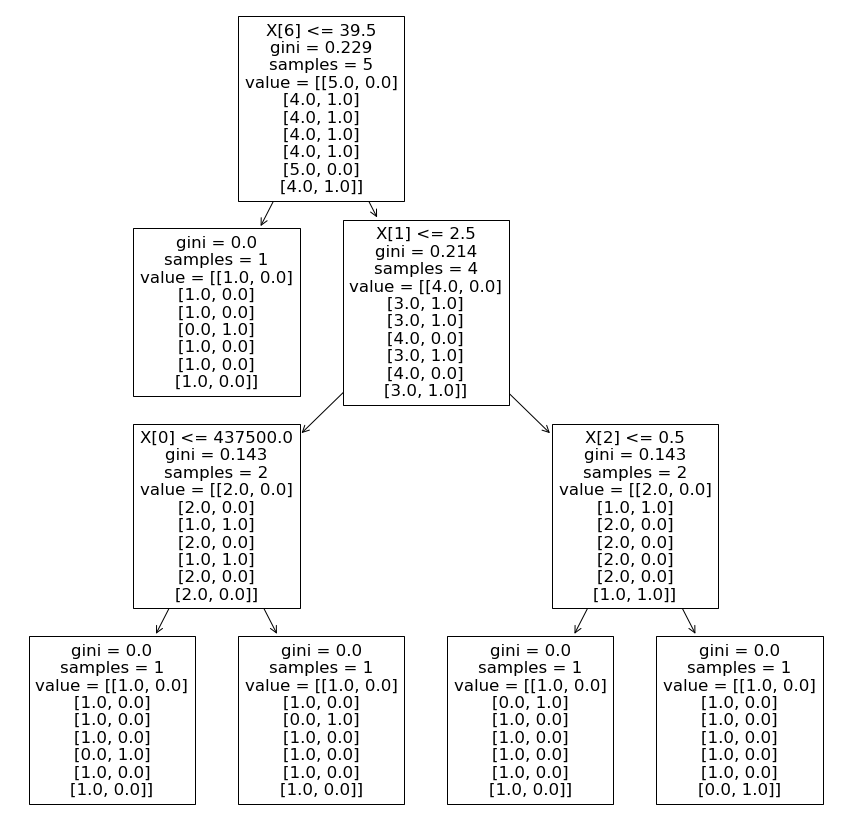

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
tree.plot_tree(dt) 
plt.show()

The decision tree looked first at violent crime and split the 5 samples with 4 <= 39.5.  Then it looked at food establishments which we did not think was critical.  We went left to the cost and the tree split even with properties less than $437500.  We went back and looked at the 2 properties and chose the lowest cost, lowest crime and shortest commute, Eastover.

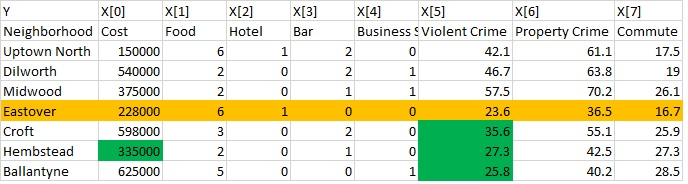

In [81]:
from IPython.display import Image
Image("dectree.jpg", width=1000, height=1000)

This is the final property chosen for our office!

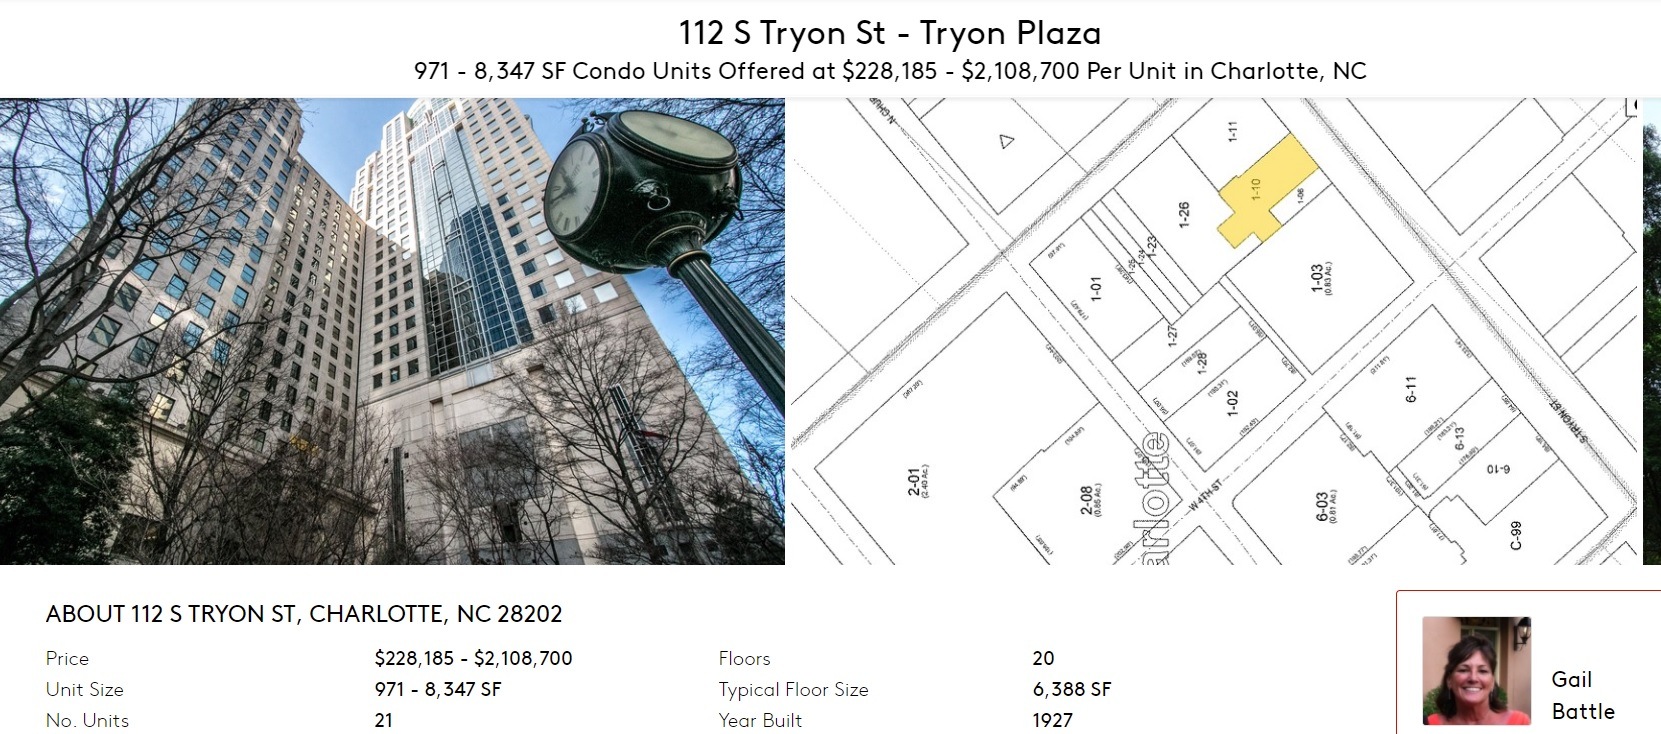

In [82]:
Image("finalresult.jpg", width=1000, height=1000)